In [1]:
#load wikitext data

train = []
test = []

train_file_path = '../Srilm/newtraincorpus.txt'
test_file_path = '../Srilm/newtestcorpus.txt'

with open(train_file_path, 'r', encoding='utf-8') as file:
    for line in file:
            # Process each line as a sentence
            words = (line.strip().split())
            train.append(words)

with open(test_file_path, 'r', encoding='utf-8') as file:
    for line in file:
            # Process each line as a sentence
            words = (line.strip().split())
            test.append(words)

print(len(train))
print(len(test))

77363
9418


In [14]:
#create vocabulary


UNK_symbol = "<UNK>"
vocab = set([UNK_symbol])



# create term frequency of the words
words_term_frequency_train = {}
for doc in train:
    for word in doc:
        # this will calculate term frequency
        # since we are taking all words now
        words_term_frequency_train[word] = words_term_frequency_train.get(word,0) + 1

# create vocabulary
for doc in train:
    for word in doc:
        if words_term_frequency_train.get(word,0) >= 5:
            vocab.add(word)

# remove "@-@" from vocab
vocab.remove("@-@")

print(len(vocab))

19114


In [15]:
#create 5-grams

import numpy as np
# create required lists
x_train = []
y_train = []

x_test = []
y_test = []


import pickle

# Load wordtoid mappings
with open("word2idmaps/5gram.pkl", 'rb') as f:
    word_to_id_mappings = pickle.load(f)

# function to get id for a given word
# return <UNK> id if not found
def get_id_of_word(word):
    unknown_word_id = word_to_id_mappings['<UNK>']
    return word_to_id_mappings.get(word,unknown_word_id)

# creating training and dev set
for sentence in train:
    for i,word in enumerate(sentence):
        if i+4 >= len(sentence):
            # sentence boundary reached
            break
        # convert word to id
        x_extract = [get_id_of_word(word),get_id_of_word(sentence[i+1]),get_id_of_word(sentence[i+2]), get_id_of_word(sentence[i+3])]
        y_extract = [get_id_of_word(sentence[i+4])]

        x_train.append(x_extract)
        y_train.append(y_extract)

for sentence in test:
    for i,word in enumerate(sentence):
        if i+4 >= len(sentence):
            # sentence boundary reached
            # ignoring sentence less than 3 words
            break
        # convert word to id
        x_extract = [get_id_of_word(word),get_id_of_word(sentence[i+1]),get_id_of_word(sentence[i+2]), get_id_of_word(sentence[i+3])]
        y_extract = [get_id_of_word(sentence[i+4])]

        x_test.append(x_extract)
        y_test.append(y_extract)
  

# making numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)  
  
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1333059, 4)
(1333059, 1)
(156022, 4)
(156022, 1)


In [16]:
# load libraries
import torch
import multiprocessing
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import time

In [17]:
# 5gramgram Neural Network Model
class fiveGramNNmodel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size, h):
        super(fiveGramNNmodel, self).__init__()
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, h)
        self.linear2 = nn.Linear(h, vocab_size, bias = False)

    def forward(self, inputs):
        # compute x': concatenation of x1 and x2 embeddings
        embeds = self.embeddings(inputs).view((-1,self.context_size * self.embedding_dim))
        # compute h: tanh(W_1.x' + b)
        out = torch.tanh(self.linear1(embeds))
        # compute W_2.h
        out = self.linear2(out)
        # compute y: log_softmax(W_2.h)
        log_probs = F.log_softmax(out, dim=1)
        # return log probabilities
        # BATCH_SIZE x len(vocab)
        return log_probs

In [18]:
# create parameters
gpu = 0 
# word vectors size
EMBEDDING_DIM = 200
CONTEXT_SIZE = 4
BATCH_SIZE = 256
# hidden units
H = 100
torch.manual_seed(13013)

# check if gpu is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
available_workers = multiprocessing.cpu_count()

print("--- Creating training and dev dataloaders with {} batch size ---".format(BATCH_SIZE))
train_set = np.concatenate((x_train, y_train), axis=1)
test_set = np.concatenate((x_test, y_test), axis=1)
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, num_workers = available_workers)
test_loader = DataLoader(test_set, batch_size = BATCH_SIZE, num_workers = available_workers)

cuda
--- Creating training and dev dataloaders with 256 batch size ---


In [19]:
model = fiveGramNNmodel(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE, H)
model.load_state_dict(torch.load("models/best_fivegram_model_3.dat"))
model.to(device)

fiveGramNNmodel(
  (embeddings): Embedding(19114, 200)
  (linear1): Linear(in_features=800, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=19114, bias=False)
)

In [20]:
# helper function to get accuracy from log probabilities
def get_accuracy_from_log_probs(log_probs, labels):
    probs = torch.exp(log_probs)
    predicted_label = torch.argmax(probs, dim=1)
    acc = (predicted_label == labels).float().mean()
    return acc, predicted_label

# helper function to evaluate model on dev data
def evaluate(model, criterion, dataloader, gpu):
    model.eval()

    mean_acc, mean_loss = 0, 0
    count = 0
    losses = []
    preds = []
    true = []
    with torch.no_grad():
        dev_st = time.time()
        for it, data_tensor in enumerate(dataloader):
            context_tensor = data_tensor[:,0:4].type(torch.LongTensor)
            target_tensor = data_tensor[:,4].type(torch.LongTensor)
            context_tensor, target_tensor = context_tensor.cuda(gpu), target_tensor.cuda(gpu)
            log_probs = model(context_tensor)
            loss = criterion(log_probs, target_tensor)
            mean_loss += loss.item()

            acc, p = get_accuracy_from_log_probs(log_probs, target_tensor)
            preds.append(p.tolist())
            true.append(target_tensor.tolist())
            mean_acc += acc
            count += 1

                
            if it % 1000 == 0: 
                print("Dev Iteration {} complete. Mean Loss: {}; Mean Acc:{}; Time taken (s): {}".format(it, mean_loss / count, mean_acc / count, (time.time()-dev_st)))
                dev_st = time.time()
                losses.append(loss.item())
    return mean_acc / count, mean_loss / count, losses, preds, true

In [21]:
# Using negative log-likelihood loss
loss_function = nn.NLLLoss()


# load it to gpu
model.cuda(gpu)




dev_acc, dev_loss, e_losses, preds, true = evaluate(model, loss_function, test_loader, gpu)


Dev Iteration 0 complete. Mean Loss: 5.9488115310668945; Mean Acc:0.21484375; Time taken (s): 21.459734439849854


In [22]:
true = [item for sublist in true for item in sublist]
len(true)

156022

In [23]:
preds = [item for sublist in preds for item in sublist]
len(preds)

156022

In [24]:
#count num correct for each different class
id_to_correct = {}
id_to_total = {}

for i, pred in enumerate(preds):
    t = true[i]

    if t in id_to_total:
        id_to_total[t] += 1
    else:
        id_to_total[t] = 1

    if t == pred:
        if pred in id_to_correct:
            id_to_correct[pred] += 1
        else:
            id_to_correct[pred] = 1
    else:
        if t not in id_to_correct:
            id_to_correct[t] = 0


In [25]:
#gonna plot accuracy vs how common it was in the training data

id_to_word_mappings = {v: k for k, v in word_to_id_mappings.items()}

accs = []
freqs = []

for id in id_to_correct:
    acc = id_to_correct[id] / id_to_total[id]

    #just gonna ignore unk
    if id_to_word_mappings[id] != '<UNK>':

        freq = words_term_frequency_train[id_to_word_mappings[id]]

        accs.append(acc)
        freqs.append(freq)
    

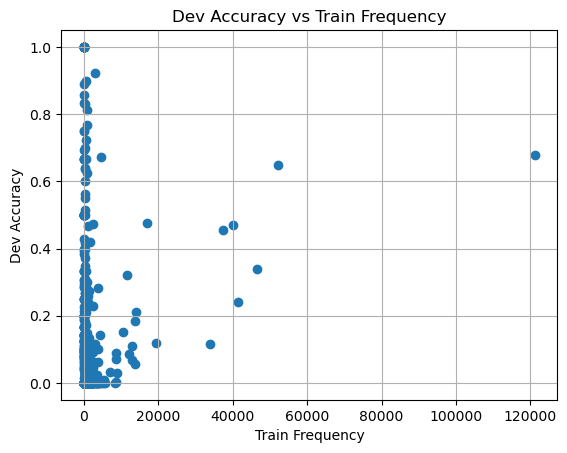

In [26]:
import matplotlib.pyplot as plt

# Plotting accuracy vs frequency as points
plt.scatter(freqs, accs, marker='o')
plt.xlabel('Train Frequency')
plt.ylabel('Dev Accuracy')
plt.title('Dev Accuracy vs Train Frequency')
plt.grid(True)
plt.show()

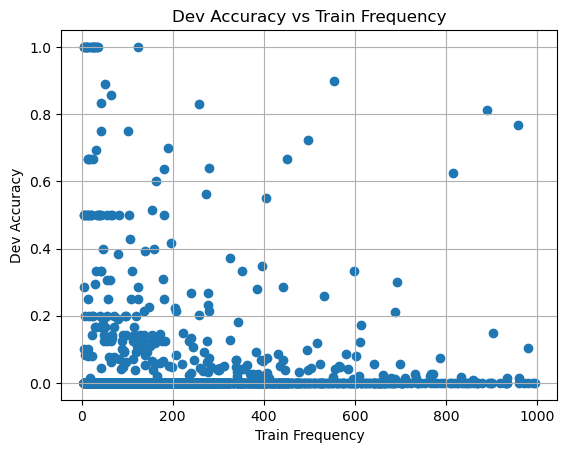

In [33]:
indices = [i for i,f in enumerate(freqs) if f < 1000]
f_accs = [accs[i] for i in indices]
f_freqs = [freqs[i] for i in indices]

# Plotting accuracy vs frequency as points
plt.scatter(f_freqs, f_accs, marker='o')
plt.xlabel('Train Frequency')
plt.ylabel('Dev Accuracy')
plt.title('Dev Accuracy vs Train Frequency')
plt.grid(True)
plt.show()